# TS6: Estimación espectral a prueba: Ancho de banda del Electrocardiograma. 
# Analisis ECG

En esta tarea realizaremos el punto 4 del TP4

4) En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:


**.Ruido causado por el movimiento de los electrodos (Alta frecuencia)**

**.Ruido muscular (Alta frecuencia)**

**.Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia)**

Ayuda: Los latidos presentes en el registro de ECG, alineados y clasificados (de origen normal y ventricular) poseen las siguientes características temporales y frecuenciales:

Analizaremos la señal de ECG muestreado a $fs=1$ KHz durante una prueba de esfuerzo. A partir del mismo trataremos de definir los parametros de la plantilla para el cálculo del filtro pasabanda.

## Elección de plantilla
### Caso $fs_1$ y $fp_1$ 

Se Estima el Espectro de la Señal con Welch

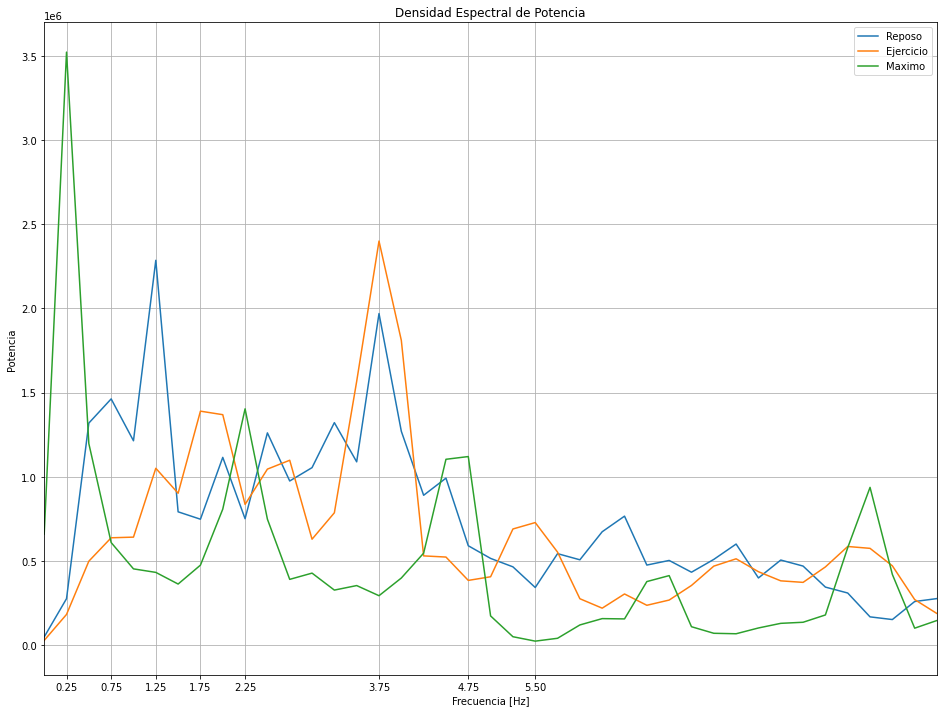

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.signal as sig


mat_struct = sio.loadmat('ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']

fs = 1000
n = [100, 300, 760, 1000, 4000] #Elijo en n que me permita tener una buena resolución en la funcion Welch

#Analizando la señal de ECG podemos notar que el paciente en esta seccion estuvo en reposo
ECG_reposo = (ecg_one_lead[0:100000])
[f, PXX_pot_reposo] = sig.welch(ECG_reposo, fs = fs,nperseg = n[4], axis = 0)

#En esta sección los latido van reduciendo su período
ECG_reposo_ejercicio = (ecg_one_lead[450000:550000])
[f, PXX_pot_ejercicio] = sig.welch(ECG_reposo_ejercicio, fs = fs,nperseg = n[4], axis = 0)

#Maximo de la señal
ECG_peak = (ecg_one_lead[750000:850000])
[f, PXX_pot_peak] = sig.welch(ECG_peak, fs = fs,nperseg = n[4], axis = 0)

plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, (PXX_pot_reposo), label = 'Reposo')
plt.plot(f, (PXX_pot_ejercicio), label = 'Ejercicio')
plt.plot(f, (PXX_pot_peak), label = 'Maximo')
plt.xlim([0,10])
plt.xticks([0.25,0.75,1.25,1.75,2.25,3.75,4.75,5.5])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia")
plt.grid()
plt.legend()

Podemos notar varios picos de potencia para las diferentes secciones de la señal. Pero *¿A que corresponden estos picos en la señal de ECG?.* 

**Anlizemos un latido de la señal de ECG original para el caso Reposo**

Text(0, 0.5, 'Amplitud')

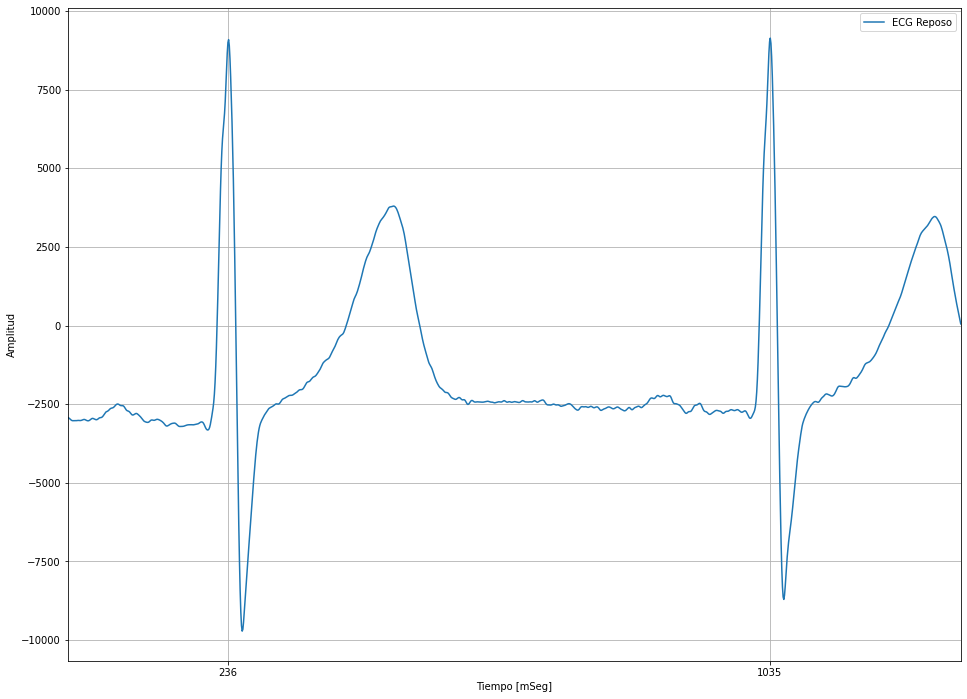

In [ ]:
plt.gcf().set_size_inches(16, 12)
plt.plot(ECG_reposo[2527:3845], label = 'ECG Reposo')
plt.autoscale(enable=True, axis='x', tight=True)
plt.xticks([236,1035])
plt.grid()
plt.legend()
plt.xlabel('Tiempo [mSeg]')
plt.ylabel('Amplitud')

Viendo el periodo de la señal como la repeticion de los picos, tenemos que:

$$f_{rep} = \dfrac{1}{(1035 - 236)*10^{-3}} Hz$$

$$ f_{rep} \approx 1,25 Hz $$


Considerando el estado del Corazon en Reposo, vemos una señal de frecuencia frep = 1,25Hz 
Al aumentar la actividad del paciente se, aumenta la frecuencia de su corazon (periodos mas cortos)

Por lo tanto definir como nuestra frecuencia de paso **$fp_1$ = 0,75Hz**

Igualmente tenemos una gran cantidad de energia en una frecuencia lenta de $0,25Hz$. Esta energía no pertenece a la señal de ECG, por lo tanto sera nuestra **$fs_1$=0,25Hz**

### Caso $fp_2$ 

A partir del analisis de la densidad espectral de potencia de la señal obtenido a traves del metodo de Welch definiremos hasta que frecuencia se encuentra el 99% de la potencia total de la ECG.

In [ ]:
Proporcion = 0.99
Energia_acu = np.cumsum(PXX_pot_reposo)

index_Energia = np.where(np.cumsum(PXX_pot_reposo)/Energia_acu[-1] > Proporcion)[0]

W_corte = f[index_Energia[0]]
W_corte #Aprox 30

29.25

Haciendo el analisis, encontramos que desde 0 hasta la 29.25Hz tenemos el 99% de la potencia total de nuestra señal de ECG. Por lo tanto nuestra frecuencia de paso **$fp_2$ = $30Hz$**

### Caso $fs_2$ 

Para encontrar la segunda frecuencia de corte analizaremos el la densidad espectral de potencia en dB.

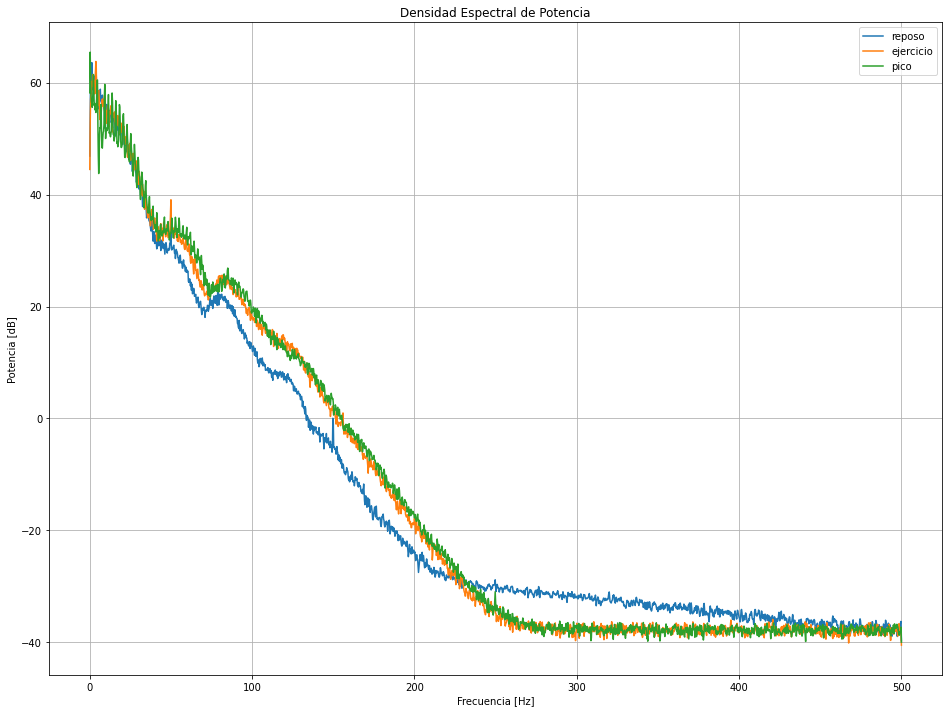

In [ ]:
plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, 10*np.log10(PXX_pot_reposo), label = 'reposo')
plt.plot(f, 10*np.log10(PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, 10*np.log10(PXX_pot_peak), label = 'pico')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel('Potencia [dB]')
#plt.xlim([0,200])
plt.grid()
plt.legend()

La frecuencia de corte **$fs_2$ = 50Hz** para reducir los picos producidos por la frecuencia de linea 

### **Plantilla Final:**

$$fs_1 = 0.25Hz$$

$$fp_1 = 0.75Hz$$

$$fp_2 = 30Hz$$

$$fs_2 = 50Hz$$

## Analisis de Latidos Normales y Ventriculares

Dentro de la estrctura **ECG_TP4.mat** utilizamos el parametro:

qrs_pattern1: Complejo de ondas QRS normal

Aca se produce el pico de la señal de ECG en [mseg]

Analizando los datos, dividimos la señal de ECG para poder distinguir los latidos Normales y Ventriculares

In [ ]:
qrs_detections = mat_struct['qrs_detections']

# Viendo el grafico podemos ver que el latido va desde 0 a 600
# qsr me da el pico del latido que se encuentra en la primera muestra en 250
# por eso si me quiero quedar con toda la informacion desde el ecg selecciono desde
# (pico - 250) hasta (pico + 350)
inferior = 250
sup = 350

latido = (ecg_one_lead[int(qrs_detections[0] - inferior):int(qrs_detections[0] + sup)])
realizaciones = np.arange(len(qrs_detections))
latidos = np.zeros([sup+inferior, qrs_detections.shape[0]])

for i in realizaciones:
    latidos[:,i] = ecg_one_lead[int(qrs_detections[i] - inferior):int(qrs_detections[i] + sup)].flatten()
    latidos[:,i]  -= np.mean(latidos[:,i]) # le resto su valor medio para centrarlos


plt.gcf().set_size_inches(16, 12)
plt.plot(latidos)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title("Latidos")
plt.xlabel('Tiempo [mSeg]')
plt.ylabel('Amplitud')

Aca podemos ver cada periodo de la señal superpuesta de ECG. Sin embargo tenemos que encontrar algun punto para poder diferenciar las normales y ventriculares. 
Buscamos un punto en el grafico donde este bien definido cuales son normales y cuales ventriculares Lo encontramos en $$(x,y) = (241, 111000)$$

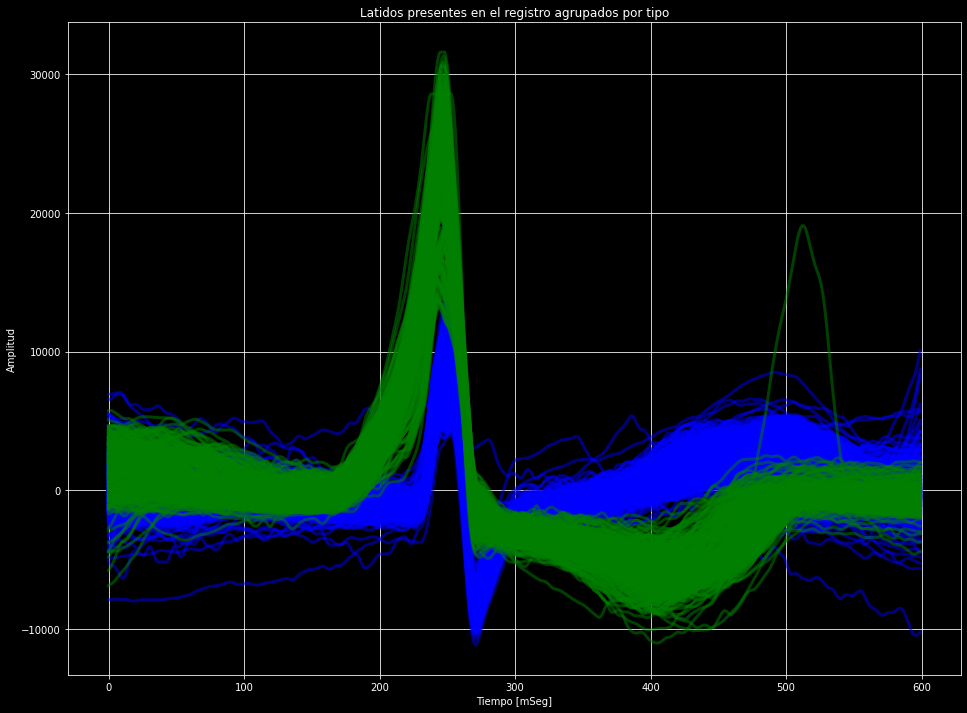

In [ ]:
slicing_latidos = latidos[241, :]

# Los que estan por debajo de 11500 son latidos normales
# Caso contrario pertenecen a la categoria de ventriculares
filtro_normal = slicing_latidos < 11100 #vector booleano
filtro_ventricular = slicing_latidos > 11100 #vector booleano

plt.gcf().set_size_inches(16, 12)

plt.plot(latidos[:,filtro_normal], 'b',alpha = 0.5, linewidth=3.0) # Normales: tomo los latidos que fueron < 11100
plt.plot(latidos[:,filtro_ventricular], 'g', alpha = 0.5,  linewidth=3.0) # Ventriculares: tomo los latidos que fueron > 11100
plt.grid()
plt.title("Latidos presentes en el registro agrupados por tipo")
plt.xlabel('Tiempo [mSeg]')
plt.ylabel('Amplitud')

plt.show()

A partir de 242 milisegundos podemos notar la diferencia entre ambos tipos de señales. Desde 11100 para abajo tenemos a los **latidos normales**. En cambio desde 11100 para arriba tenemos a las señales del tipo **ventricular**. Procedemos a separar ambas señales

Dividimos los latidos en dos señales: latidos normales y latidos ventriculares 

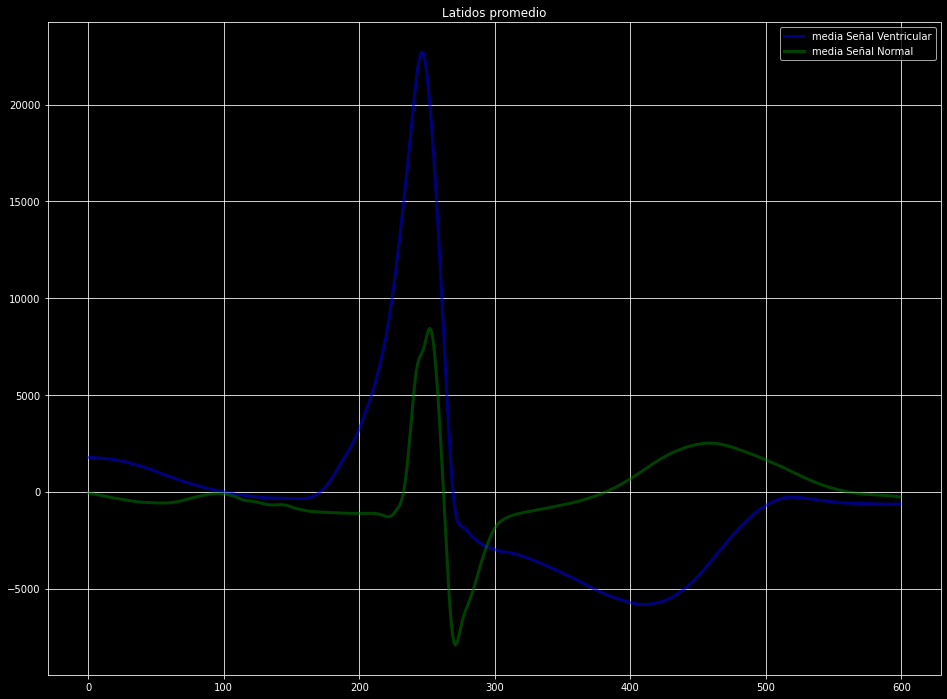

In [ ]:
#Por ultimo buscamos graficar una latido ventricular y uno normal que representa la media de
#lo que venimos haciendo

plt.gcf().set_size_inches(16, 12)

lat_vent = np.mean(latidos[:,filtro_ventricular], axis = 1) # media de la Señal Ventricular 
lat_norm = np.mean(latidos[:,filtro_normal], axis = 1) # media de la Señal Normal

plt.plot(lat_vent, 'b', label = 'media Señal Ventricular',alpha = 0.5, linewidth=3.0)
plt.plot(lat_norm, 'g', label = 'media Señal Normal', alpha = 0.5,  linewidth=3.0)
plt.legend()
plt.grid()
plt.title("Latidos promedio")


plt.show()

Conclusion: pudimos separar una señal Ventricular que muestra como se despolarizan los Ventriculos